In this notebook, we set up a binary system, with the primary having a DM spike around it. We then evolve for a number of orbits and plot the orbital properties over time.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from NbodyIMRI import tools, particles, simulator, reader
from NbodyIMRI import units as u
from NbodyIMRI import distributionfunctions as DF
import NbodyIMRI

#### Setting up the system parameters


In [3]:
M_1 = 1e6*u.Msun
M_2 = 1*u.Msun

r_isco = tools.calc_risco(M_1)

a_i = 100*r_isco
e_i = 0.0

rho_6 = 1e16*u.Msun/u.pc**3 #Normalisation of the spike
r_t  = 20*a_i   #Artificial truncation radius of the spike

N_DM = 1000

#### Generating initial conditions

This works exactly the same as for an isolated binary, but now we pass extra parameters associated with the DM spike:

> Particle set:
>     M_1 [M_sun] = 1000000.0
>     M_2 [M_sun] = 1.0
>     (a [pc], e) = (2.8672733333333327e-05, 0.0)
 
>     N_DM = 1000
>     M_DM [M_sun] = 0.01045382592413845


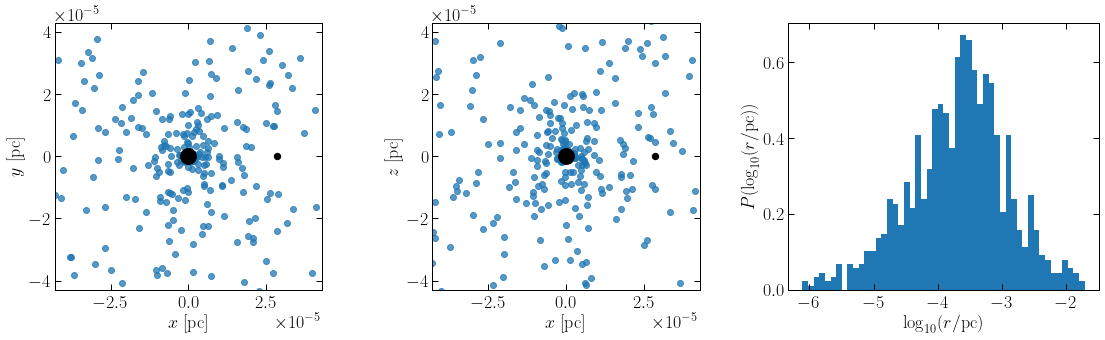

In [4]:
p_binary = particles.particles_in_binary(M_1, M_2, a_i, e_i, N_DM = N_DM, rho_6 = rho_6, r_t=r_t)

p_binary.summary()
p_binary.plot()

#### Setting up the simulator and simulation parameters

In [5]:
sim = simulator.simulator(p_binary, r_soft_sq = (1e-8*u.pc)**2)

T_orb = p_binary.T_orb()
N_step_per_orb = 10000 #10000 steps per orbit generally seems like a good idea...
N_orb = 10

t_end = T_orb*N_orb
dt    = T_orb/N_step_per_orb

sim.run_simulation(dt, t_end, show_progress=True)

  0%|          | 123/100000 [00:00<01:21, 1222.35it/s]

> Simulating...


100%|██████████| 100000/100000 [01:11<00:00, 1407.23it/s]

> Simulation completed.


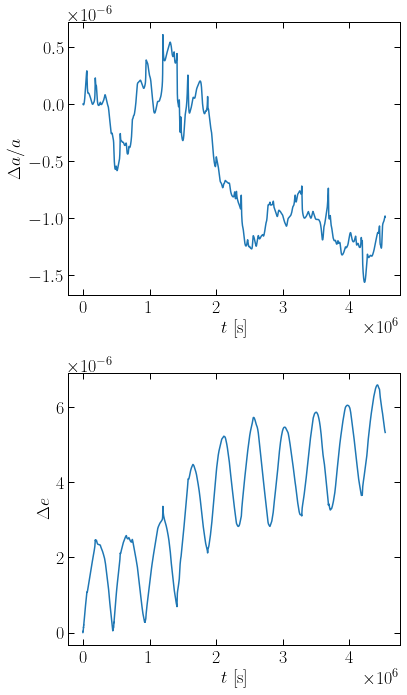

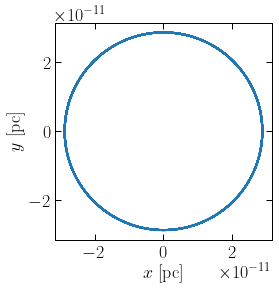

In [6]:
sim.plot_orbital_elements();
sim.plot_trajectory();

Here, we can see changes in the energy of the binary (or equivalently the semi-major axis), caused by gravitational interactions with the DM pseudoparticles. It's a stochastic process, and quite noisy. To check if it's real, we'll need to increase the number of DM pseudoparticles, which should reduce these noisy fluctuations. 